In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
df = pd.read_parquet("../data/coin-data-hourly.parquet")

In [3]:
df

,Date,Close,High,Low,Open,Volume,Symbol
0,2024-01-20 00:00:00,41480.117188,41640.230469,41446.824219,41624.589844,0,BTC-USD
1,2024-01-20 01:00:00,41604.789062,41646.871094,41469.070312,41469.070312,0,BTC-USD
2,2024-01-20 02:00:00,41575.363281,41622.125000,41522.097656,41622.125000,0,BTC-USD
3,2024-01-20 03:00:00,41624.578125,41624.578125,41512.343750,41589.242188,0,BTC-USD
4,2024-01-20 04:00:00,41585.972656,41630.390625,41562.292969,41611.378906,0,BTC-USD
...,...,...,...,...,...,...,...
17344,2026-01-18 04:00:00,95059.859375,95146.000000,95038.898438,95121.054688,0,BTC-USD
17345,2026-01-18 05:00:00,95154.515625,95189.578125,95025.656250,95059.390625,149681152,BTC-USD
17346,2026-01-18 06:00:00,95136.492188,95171.390625,95112.210938,95134.304688,37563392,BTC-USD
17347,2026-01-18 07:00:00,95023.484375,95141.304688,94995.929688,95137.250000,156658688,BTC-USD


In [4]:
df = pd.read_parquet("../data/coin-data-hourly.parquet")


def add_features(df):
    df = df.copy()
    df.sort_values(["Symbol", "Date"], inplace=True)

    df["Date"] = pd.to_datetime(df["Date"])

    def compute_indicators(group):
        group.ta.ema(length=9, append=True)
        group.ta.ema(length=21, append=True)
        group.ta.ema(length=50, append=True)
        group.ta.ema(length=100, append=True)
        group.ta.ema(length=200, append=True)
        group.ta.rsi(length=14, append=True)
        group.ta.stochrsi(length=14, append=True)
        group.ta.cci(length=20, append=True)
        group.ta.adx(length=14, append=True)
        group.ta.bbands(length=20, std=2, append=True)
        group.ta.atr(length=14, append=True)
        group.ta.obv(append=True)
        group.ta.mfi(length=14, append=True)
        group.ta.cmf(length=20, append=True)
        group.ta.log_return(append=True)
        group.ta.macd(fast=12, slow=26, signal=9, append=True)
        return group

    def rename_columns(group):
        rename_map = {
            "EMA_9": "EMA_SHORT",
            "EMA_21": "EMA_MID",
            "EMA_50": "EMA_LONG",
            "EMA_200": "EMA_TREND",
            "RSI_14": "RSI",
            "STOCHRSIk_14_14_3_3": "STOCH_K",
            "STOCHRSId_14_14_3_3": "STOCH_D",
            "ADX_14": "ADX",
            "DMP_14": "ADX_POS",
            "DMN_14": "ADX_NEG",
            "CCI_20_0.015": "CCI",
            "ATRr_14": "ATR",
            "MFI_14": "MFI",
            "CMF_20": "CMF",
            "OBV": "OBV",
            "LOGRET_1": "LOG_RET",
            "MACD_12_26_9": "MACD_LINE",
            "MACDh_12_26_9": "MACD_HIST",
            "MACDs_12_26_9": "MACD_SIGNAL",
            "BBU_20_2.0": "BB_UPPER",
            "BBL_20_2.0": "BB_LOWER",
            "BBM_20_2.0": "BB_MID",
        }
        cols_found = [c for c in rename_map.keys() if c in group.columns]
        actual_map = {k: rename_map[k] for k in cols_found}
        group.rename(columns=actual_map, inplace=True)
        return group

    def custom_features(group):
        close = group["Close"]
        open_ = group["Open"]
        high = group["High"]
        low = group["Low"]

        group["candle_body"] = abs(close - open_)
        group["candle_range"] = high - low
        group["upper_wick"] = high - group[["Open", "Close"]].max(axis=1)
        group["lower_wick"] = group[["Open", "Close"]].min(axis=1) - low
        group["upper_wick_ratio"] = group["upper_wick"] / (group["candle_body"] + 1e-9)
        group["lower_wick_ratio"] = group["lower_wick"] / (group["candle_body"] + 1e-9)

        vol_ma = group["Volume"].rolling(window=24).mean()
        group["RVOL"] = group["Volume"] / (vol_ma + 1e-9)

        group["dist_ema_short"] = (close - group["EMA_SHORT"]) / group["EMA_SHORT"]
        group["dist_ema_long"] = (close - group["EMA_LONG"]) / group["EMA_LONG"]

        if "BB_UPPER" in group.columns and "BB_LOWER" in group.columns:
            group["bb_position"] = (close - group["BB_LOWER"]) / (
                group["BB_UPPER"] - group["BB_LOWER"]
            )
            group["bb_width"] = (group["BB_UPPER"] - group["BB_LOWER"]) / group[
                "BB_MID"
            ]

        if "MFI" in group.columns:
            group["rsi_mfi_diff"] = group["RSI"] - group["MFI"]

        if "ADX" in group.columns:
            group["is_trending"] = (group["ADX"] > 25).astype(int)

        return group

    def add_time_features(group):

        date_col = pd.to_datetime(group["Date"])

        group["hour"] = date_col.dt.hour
        group["day_of_week"] = date_col.dt.dayofweek
        group["day_of_month"] = date_col.dt.day
        group["month"] = date_col.dt.month
        group["quarter"] = date_col.dt.quarter
        group["week_of_year"] = date_col.dt.isocalendar().week

        group["hour_sin"] = np.sin(2 * np.pi * group["hour"] / 24)
        group["hour_cos"] = np.cos(2 * np.pi * group["hour"] / 24)

        group["day_sin"] = np.sin(2 * np.pi * group["day_of_week"] / 7)
        group["day_cos"] = np.cos(2 * np.pi * group["day_of_week"] / 7)

        group["month_sin"] = np.sin(2 * np.pi * group["month"] / 12)
        group["month_cos"] = np.cos(2 * np.pi * group["month"] / 12)

        group["is_weekend"] = (group["day_of_week"] >= 5).astype(int)  # Cumartesi/Pazar

        group["is_asian_hours"] = ((group["hour"] >= 0) & (group["hour"] < 8)).astype(
            int
        )
        group["is_european_hours"] = (
            (group["hour"] >= 8) & (group["hour"] < 16)
        ).astype(int)
        group["is_us_hours"] = ((group["hour"] >= 16) & (group["hour"] < 24)).astype(
            int
        )

        group["is_market_open"] = ((group["hour"] >= 9) & (group["hour"] <= 16)).astype(
            int
        )
        group["is_morning"] = ((group["hour"] >= 6) & (group["hour"] < 12)).astype(int)
        group["is_afternoon"] = ((group["hour"] >= 12) & (group["hour"] < 18)).astype(
            int
        )
        group["is_evening"] = ((group["hour"] >= 18) & (group["hour"] < 24)).astype(int)
        group["is_night"] = ((group["hour"] >= 0) & (group["hour"] < 6)).astype(int)

        group["is_month_start"] = (group["day_of_month"] <= 5).astype(int)
        group["is_month_end"] = (group["day_of_month"] >= 25).astype(int)

        group["is_quarter_start"] = (
            (group["month"] % 3 == 1) & (group["day_of_month"] <= 5)
        ).astype(int)
        group["is_quarter_end"] = (
            (group["month"] % 3 == 0) & (group["day_of_month"] >= 25)
        ).astype(int)

        return group

    def add_lags(group):
        cols_to_lag = ["LOG_RET", "RSI", "MACD_HIST", "RVOL", "MFI"]
        for col in cols_to_lag:
            if col in group.columns:
                group[f"{col}_lag1"] = group[col].shift(1)
                group[f"{col}_lag2"] = group[col].shift(2)
        return group

    df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
    df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
    df = df.groupby("Symbol", group_keys=False).apply(custom_features)
    df = df.groupby("Symbol", group_keys=False).apply(add_time_features)
    df = df.groupby("Symbol", group_keys=False).apply(add_lags)

    df.dropna(inplace=True)
    return df


df = add_features(df)

/tmp/ipykernel_89140/956797667.py:156: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
/tmp/ipykernel_89140/956797667.py:157: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
/tmp/ipykernel_89140/956797667.py:158: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

In [5]:
df["next_close"] = df.groupby("Symbol")["Close"].shift(-4)

threshold = 0.002

conditions = [
    df["next_close"] < df["Close"] * (1 - threshold),
    df["next_close"] > df["Close"] * (1 + threshold),
]

choices = [0, 2]

df["Target"] = np.select(conditions, choices, default=1)

df.dropna(subset=["next_close"], inplace=True)
df.drop(columns=["next_close"], inplace=True)

print(df["Target"].value_counts().sort_index())

Target
0    5935
1    4416
2    6456
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

df = df.sort_values(by="Date")

drop_cols = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Target",
    "Date",
    "Symbol",
]

X = df.drop(columns=drop_cols, errors="ignore")
y = df["Target"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test, X_backtest, y_test, y_backtest = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

In [7]:
X_train.columns

Index(['EMA_SHORT', 'EMA_MID', 'EMA_LONG', 'EMA_100', 'EMA_TREND', 'RSI',
       'STOCH_K', 'STOCH_D', 'CCI', 'ADX', 'ADXR_14_2', 'ADX_POS', 'ADX_NEG',
       'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0',
       'BBP_20_2.0_2.0', 'ATR', 'OBV', 'MFI', 'CMF', 'LOG_RET', 'MACD_LINE',
       'MACD_HIST', 'MACD_SIGNAL', 'candle_body', 'candle_range', 'upper_wick',
       'lower_wick', 'upper_wick_ratio', 'lower_wick_ratio', 'RVOL',
       'dist_ema_short', 'dist_ema_long', 'rsi_mfi_diff', 'is_trending',
       'hour', 'day_of_week', 'day_of_month', 'month', 'quarter',
       'week_of_year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'month_sin', 'month_cos', 'is_weekend', 'is_asian_hours',
       'is_european_hours', 'is_us_hours', 'is_market_open', 'is_morning',
       'is_afternoon', 'is_evening', 'is_night', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'LOG_RET_lag1',
       'LOG_RET_lag2', 'RSI_lag1', 'RSI_lag2', 'MAC

In [23]:
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

xgb_params = {
    "learning_rate": 0.1,
    "n_estimators": 250,
    "max_depth": 3,
    "random_state": 42,
    "reg_alpha": 0.5,
    "reg_lambda": 0.5,
    "objective": "multi:softprob",
}

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

xgb = XGBClassifier(**xgb_params)
xgb.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
)

all_probs = xgb.predict_proba(X_test)
probs_short = all_probs[:, 0]
probs_long = all_probs[:, 2]

header = (
    f"{'Threshold':<10} | "
    f"{'L-Prec':<8} {'L-Rec':<8} {'L-Count':<8} | "
    f"{'S-Prec':<8} {'S-Rec':<8} {'S-Count':<8}"
)

print(header)
print("-" * len(header))

for threshold in np.linspace(0.2, 0.8, 12):

    preds_long = (probs_long > threshold).astype(int)
    actual_long = (y_test == 2).astype(int)

    prec_long = precision_score(actual_long, preds_long, zero_division=0)
    rec_long = recall_score(actual_long, preds_long, zero_division=0)
    count_long = preds_long.sum()

    preds_short = (probs_short > threshold).astype(int)
    actual_short = (y_test == 0).astype(int)

    prec_short = precision_score(actual_short, preds_short, zero_division=0)
    rec_short = recall_score(actual_short, preds_short, zero_division=0)
    count_short = preds_short.sum()

    print(
        f"{threshold:<10.2f} | "
        f"{prec_long:<8.2f} {rec_long:<8.2f} {count_long:<8} | "
        f"{prec_short:<8.2f} {rec_short:<8.2f} {count_short:<8}"
    )

Threshold  | L-Prec   L-Rec    L-Count  | S-Prec   S-Rec    S-Count 
--------------------------------------------------------------------
0.20       | 0.36     0.88     1411     | 0.37     0.82     1252    
0.25       | 0.37     0.70     1109     | 0.37     0.59     892     
0.31       | 0.39     0.45     672      | 0.35     0.34     544     
0.36       | 0.40     0.23     326      | 0.34     0.21     346     
0.42       | 0.46     0.13     160      | 0.36     0.15     228     
0.47       | 0.48     0.07     86       | 0.42     0.13     168     
0.53       | 0.55     0.04     47       | 0.43     0.11     138     
0.58       | 0.45     0.02     22       | 0.41     0.07     100     
0.64       | 0.44     0.01     9        | 0.42     0.06     80      
0.69       | 0.50     0.00     2        | 0.43     0.04     47      
0.75       | 0.50     0.00     2        | 0.48     0.03     29      
0.80       | 0.00     0.00     1        | 0.32     0.01     19      


Calculating backtest...


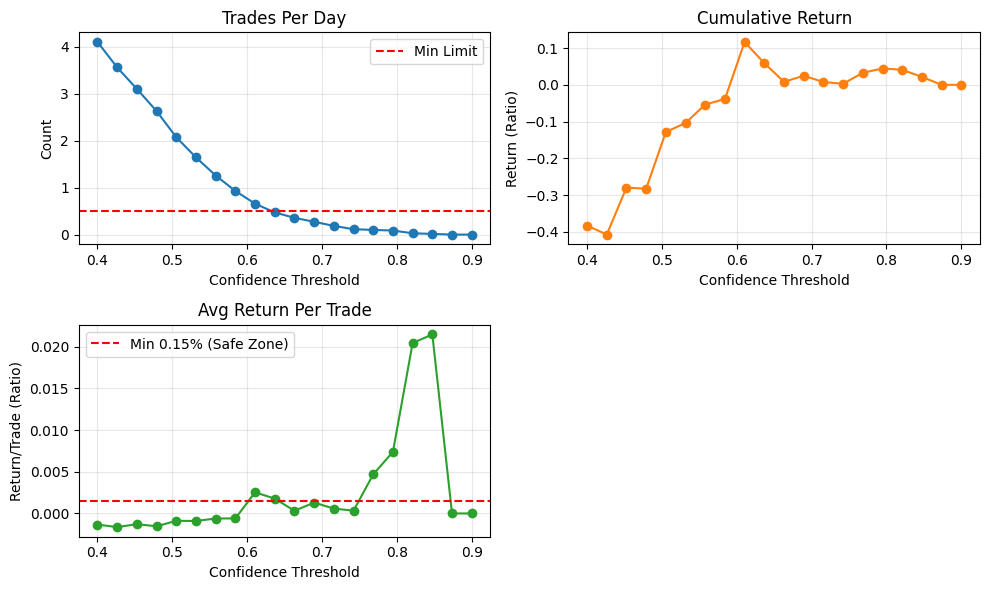

Max Return Stats (Filtered > 0.5 trades/day):
Best Threshold: 0.611
Trades: 46
Trade per day: 0.66
Total Return: 11.65%
Return per trade: 0.253%


In [24]:
# fmt: off

all_probs = xgb.predict_proba(X_backtest)
probs_short = all_probs[:, 0]
probs_long = all_probs[:, 2]

analysis = pd.DataFrame(
    {
        "Symbol": df.loc[X_backtest.index, "Symbol"],
        "Open": df.loc[X_backtest.index, "Open"],
        "Low": df.loc[X_backtest.index, "Low"],
        "High": df.loc[X_backtest.index, "High"],
        "Close": df.loc[X_backtest.index, "Close"],
        "Prob_Short": probs_short,
        "Prob_Long": probs_long,
        "Date": df.loc[X_backtest.index, "Date"],
    }
)
analysis = analysis.sort_values("Date").reset_index(drop=True)

thresholds = np.linspace(0.4, 0.9, 20)
returns = []
trade_amounts = []

TAKE_PROFIT = 0.02
STOP_LOSS = 0.01
COMMISSION = 0.001
INITIAL_CAPITAL = 10000.0
HOLD_PERIOD = 4

print("Calculating backtest...")

for threshold in thresholds:
    trade_count = 0
    
    conditions = [analysis["Prob_Long"] > threshold, analysis["Prob_Short"] > threshold]
    choices = [1, -1]
    raw_signals = np.select(conditions, choices, default=0)
    
    signals = pd.Series(raw_signals).shift(1).fillna(0).values
    
    current_capital = INITIAL_CAPITAL
    position = 0
    entry_price = 0.0
    exit_step_limit = 0
    
    open_arr = analysis["Open"].values
    low_arr = analysis["Low"].values
    high_arr = analysis["High"].values
    close_arr = analysis["Close"].values
    
    for i in range(len(analysis)):
        current_open = open_arr[i]
        
        if position != 0:
            execute_exit = False
            exit_price = 0.0
            
            if position == 1:
                sl_price = entry_price * (1 - STOP_LOSS)
                tp_price = entry_price * (1 + TAKE_PROFIT)
                
                if low_arr[i] <= sl_price:
                    exit_price = min(current_open, sl_price) if current_open < sl_price else sl_price
                    execute_exit = True
                elif high_arr[i] >= tp_price:
                    exit_price = max(current_open, tp_price) if current_open > tp_price else tp_price
                    execute_exit = True
                elif i >= exit_step_limit:
                    exit_price = close_arr[i]
                    execute_exit = True
                
                if execute_exit:
                    raw_return = (exit_price - entry_price) / entry_price

            elif position == -1:
                sl_price = entry_price * (1 + STOP_LOSS)
                tp_price = entry_price * (1 - TAKE_PROFIT)
                
                if high_arr[i] >= sl_price:
                    exit_price = max(current_open, sl_price) if current_open > sl_price else sl_price
                    execute_exit = True
                elif low_arr[i] <= tp_price:
                    exit_price = min(current_open, tp_price) if current_open < tp_price else tp_price
                    execute_exit = True
                elif i >= exit_step_limit:
                    exit_price = close_arr[i]
                    execute_exit = True
                
                if execute_exit:
                    raw_return = (entry_price - exit_price) / entry_price

            if execute_exit:
                current_capital = current_capital * (1 + raw_return - COMMISSION)
                position = 0
    
        elif position == 0 and signals[i] != 0:
            position = signals[i]
            entry_price = current_open
            exit_step_limit = i + HOLD_PERIOD
            trade_count += 1

    total_return = (current_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL
    returns.append(total_return)
    trade_amounts.append(trade_count)

trade_per_day = [count * 24 / len(analysis) for count in trade_amounts]
return_per_trade = [r / c if c > 0 else 0.0 for r, c in zip(returns, trade_amounts)]

TPD_THRESHOLD = 0.5 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))

ax1.plot(thresholds, trade_per_day, marker="o", color="tab:blue")
ax1.set_title("Trades Per Day")
ax1.set_xlabel("Confidence Threshold")
ax1.set_ylabel("Count")
ax1.grid(True, alpha=0.3)
ax1.axhline(TPD_THRESHOLD, ls="--", color="red", label="Min Limit")
ax1.legend()

ax2.plot(thresholds, returns, marker="o", color="tab:orange")
ax2.set_title("Cumulative Return")
ax2.set_xlabel("Confidence Threshold")
ax2.set_ylabel("Return (Ratio)")
ax2.grid(True, alpha=0.3)

ax3.plot(thresholds, return_per_trade, marker="o", color="tab:green")
ax3.set_title("Avg Return Per Trade")
ax3.set_xlabel("Confidence Threshold")
ax3.set_ylabel("Return/Trade (Ratio)")
ax3.grid(True, alpha=0.3)
ax3.axhline(0.0015, ls="--", color="red", label="Min 0.15% (Safe Zone)") 
ax3.legend()

ax4.axis('off')

plt.tight_layout()
plt.show()

valid_indices = [i for i, tpd in enumerate(trade_per_day) if tpd > TPD_THRESHOLD]

if valid_indices:
    best_pos = np.argmax([return_per_trade[i] for i in valid_indices])
    best_idx = valid_indices[best_pos]

    print(f"Max Return Stats (Filtered > {TPD_THRESHOLD} trades/day):")
    print(f"Best Threshold: {thresholds[best_idx]:.3f}")
    print(f"Trades: {trade_amounts[best_idx]}")
    print(f"Trade per day: {trade_per_day[best_idx]:.2f}")
    print(f"Total Return: {returns[best_idx]*100:.2f}%")
    print(f"Return per trade: {return_per_trade[best_idx]*100:.3f}%")
else:
    print("No threshold met the minimum trade frequency requirement.")

# fmt: on